🔹 1. Imports & Configurations

In [1]:
# === Basic Utilities ===
import os, random, shutil, warnings
from pathlib import Path
from collections import defaultdict

# === Data Handling ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from time import time

# === Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt

# === Image Handling ===
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.simplefilter('error', Image.DecompressionBombWarning)

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# === CLIP (for filtering) ===
import clip
import torch
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from collections import Counter, defaultdict

# === Paths ===
metadata_path = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\metadata.csv"
source_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species1"
dest_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_filtered"
dest_dir_clip = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final"
dest_dir_removed = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_removed"

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load metadata
metadata = pd.read_csv(metadata_path)
"""
This cell loads the metadata CSV file and analyzes the distribution of images across families.
It counts and calculates the percentage of images per family to assess dataset balance.
The output helps identify potential class imbalances that may need addressing.
"""
# Calculate image counts per family
family_stats = metadata['family'].value_counts().reset_index()
family_stats.columns = ['Family', 'Image Count']
family_stats['Percentage'] = (family_stats['Image Count'] / family_stats['Image Count'].sum()) * 100

# Display results
print("Dataset Balance by Family:")
print(family_stats.to_string(index=False))

Dataset Balance by Family:
           Family  Image Count  Percentage
  cercopithecidae          300    2.503547
      dactyloidae          300    2.503547
       formicidae          291    2.428440
   plethodontidae          270    2.253192
   carcharhinidae          270    2.253192
    salamandridae          270    2.253192
          bovidae          240    2.002837
      bucerotidae          210    1.752483
      acroporidae          210    1.752483
         anatidae          180    1.502128
      diomedeidae          180    1.502128
         atelidae          150    1.251773
          laridae          150    1.251773
           apidae          150    1.251773
        bufonidae          150    1.251773
       dasyatidae          150    1.251773
      delphinidae          120    1.001419
      agariciidae          120    1.001419
   callitrichidae          120    1.001419
      psittacidae          120    1.001419
     spheniscidae          120    1.001419
        iguanidae          

In [3]:
"""
This cell loads the metadata CSV file and analyzes the distribution of images across families.
It counts and calculates the percentage of images per family to assess dataset balance.
The output helps identify potential class imbalances that may need addressing.
"""
# Calculate image counts per family
family_stats = metadata['phylum'].value_counts().reset_index()
family_stats.columns = ['phylum', 'Image Count']
family_stats['Percentage'] = (family_stats['Image Count'] / family_stats['Image Count'].sum()) * 100

# Display results
print("Dataset Balance by phylum:")
print(family_stats.to_string(index=False))

Dataset Balance by phylum:
       phylum  Image Count  Percentage
     chordata         9952   83.050989
   arthropoda          951    7.936243
     cnidaria          810    6.759576
     mollusca          210    1.752483
echinodermata           60    0.500709


🔹 2. Image Filtering (Low Quality & Corrupted)

In [4]:
valid_formats = ['jpeg', 'jpg', 'png', 'bmp']
min_size_kb = 5
max_pixels = 89_478_485

os.makedirs(dest_dir, exist_ok=True)

total_images = valid_images = removed_small = removed_too_large = removed_invalid = 0

for family_folder in os.listdir(source_dir):
    src_path = os.path.join(source_dir, family_folder)
    dst_path = os.path.join(dest_dir, family_folder)
    os.makedirs(dst_path, exist_ok=True)

    for file in os.listdir(src_path):
        total_images += 1
        file_path = os.path.join(src_path, file)
        try:
            if os.path.getsize(file_path) < min_size_kb * 1024:
                removed_small += 1
                continue
            with Image.open(file_path) as img:
                if img.format.lower() not in valid_formats:
                    removed_invalid += 1
                    continue
                if img.width * img.height > max_pixels:
                    removed_too_large += 1
                    continue
                img.verify()
            shutil.copy2(file_path, os.path.join(dst_path, file))
            valid_images += 1
        except Exception:
            removed_invalid += 1

print(f"\nImage filtering complete. Valid: {valid_images}, Removed: {total_images - valid_images}")


Image filtering complete. Valid: 11972, Removed: 11


🔹 3. CLIP-Based Filtering (Similarity)

In [5]:
# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dest_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_filtered"
dest_dir_clip = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final"
dest_dir_removed = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_removed"

def get_clip_embedding(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            return model.encode_image(img_tensor).cpu().numpy()[0]
    except Exception as e:
        print(f" Error processing {image_path}: {e}")
        return None

# === Track removals
removal_counter = defaultdict(int)
total_removed = 0
total_processed = 0

folder_counter = 0
for folder in tqdm(os.listdir(dest_dir), desc="CLIP cleaning"):
    folder_counter += 1
    fpath = os.path.join(dest_dir, folder)
    f_keep = os.path.join(dest_dir_clip, folder)
    f_rm = os.path.join(dest_dir_removed, folder)
    os.makedirs(f_keep, exist_ok=True)
    os.makedirs(f_rm, exist_ok=True)

    image_paths, embeddings = [], []
    for file in os.listdir(fpath):
        full_path = os.path.join(fpath, file)
        emb = get_clip_embedding(full_path)
        if emb is not None:
            image_paths.append(full_path)
            embeddings.append(emb)

    total_processed += len(image_paths)

    if len(embeddings) < 3:
        for img in image_paths:
            shutil.copy2(img, os.path.join(f_keep, os.path.basename(img)))
        print(f"\n {folder}: Kept all {len(image_paths)} images (too few for clustering)")
        continue

    embeddings = np.vstack(embeddings)

    # === Clustering with DBSCAN ===
    db = DBSCAN(eps=0.3, min_samples=2, metric="cosine").fit(embeddings)
    labels = db.labels_

    if len(set(labels)) == 1 and -1 in labels:
        print(f"\n {folder}: All images marked as noise. Keeping all.")
        for img in image_paths:
            shutil.copy2(img, os.path.join(f_keep, os.path.basename(img)))
        continue

    label_counts = Counter(labels)
    label_counts.pop(-1, None)
    if not label_counts:
        print(f"\n {folder}: No valid clusters found. Keeping all.")
        for img in image_paths:
            shutil.copy2(img, os.path.join(f_keep, os.path.basename(img)))
        continue

    majority_label = label_counts.most_common(1)[0][0]
    kept_files = []
    removed_files = []

    for i, img_path in enumerate(image_paths):
        filename = os.path.basename(img_path)
        if labels[i] == majority_label:
            shutil.copy2(img_path, os.path.join(f_keep, filename))
            kept_files.append(filename)
        else:
            shutil.copy2(img_path, os.path.join(f_rm, filename))
            removed_files.append(filename)

    removal_counter[folder] += len(removed_files)
    total_removed += len(removed_files)

    print(f"\n {folder}:")
    print(f"   Kept: {len(kept_files)}/{len(image_paths)} ({100 * len(kept_files) / len(image_paths):.1f}%)")
    print(f"   Removed: {len(removed_files)}")

    if folder_counter <= 5:
        print(f"  🔎 Examples:")
        print(f"    Kept    : {kept_files[:5]}")
        print(f"    Removed : {removed_files[:5]}")

# === Final Summary ===
print("\n===  CLIP + Clustering Complete ===")
print(f" Final images saved to: {dest_dir_clip}")
print(f" Removed images saved to: {dest_dir_removed}")

print("\n📊 Removal Summary Per Family:")
for family, removed in removal_counter.items():
    print(f" - {family}: {removed} images removed")

print(f"\n Total Removed: {total_removed} / {total_processed} images")
print(f" Percentage Removed: {100 * total_removed / total_processed:.2f}%")



CLIP cleaning:   0%|          | 1/202 [00:24<1:22:44, 24.70s/it]


 arthropoda_apidae:
   Kept: 150/150 (100.0%)
   Removed: 0
  🔎 Examples:
    Kept    : ['20647903_1065369_eol-full-size-copy.jpg', '20647904_1065369_eol-full-size-copy.jpg', '20647909_1065369_eol-full-size-copy.jpg', '20647915_1065369_eol-full-size-copy.jpg', '21834153_1065290_eol-full-size-copy.jpg']
    Removed : []


CLIP cleaning:   1%|          | 2/202 [00:29<43:39, 13.10s/it]  


 arthropoda_attelabidae:
   Kept: 29/30 (96.7%)
   Removed: 1
  🔎 Examples:
    Kept    : ['14088426_52691998_eol-full-size-copy.jpg', '14088427_52691998_eol-full-size-copy.jpg', '14088429_52691998_eol-full-size-copy.jpg', '14088430_52691998_eol-full-size-copy.jpg', '22864939_52691998_eol-full-size-copy.jpg']
    Removed : ['29600192_52691998_eol-full-size-copy.jpg']


CLIP cleaning:   1%|▏         | 3/202 [00:38<36:45, 11.08s/it]


 arthropoda_carabidae:
   Kept: 59/60 (98.3%)
   Removed: 1
  🔎 Examples:
    Kept    : ['10787825_2867406_eol-full-size-copy.jpg', '10787827_2867406_eol-full-size-copy.jpg', '10787828_2867406_eol-full-size-copy.jpg', '10787831_2867406_eol-full-size-copy.jpg', '10787833_2867406_eol-full-size-copy.jpg']
    Removed : ['28933416_2867406_eol-full-size-copy.jpg']


CLIP cleaning:   2%|▏         | 4/202 [00:42<27:53,  8.45s/it]


 arthropoda_cerambycidae:
   Kept: 28/29 (96.6%)
   Removed: 1
  🔎 Examples:
    Kept    : ['14204113_354871_eol-full-size-copy.jpg', '22538999_354871_eol-full-size-copy.jpg', '22539000_354871_eol-full-size-copy.jpg', '22539001_354871_eol-full-size-copy.jpg', '22539002_354871_eol-full-size-copy.jpg']
    Removed : ['28255130_354871_eol-full-size-copy.jpg']


CLIP cleaning:   2%|▏         | 5/202 [00:46<22:17,  6.79s/it]


 arthropoda_coenagrionidae:
   Kept: 30/30 (100.0%)
   Removed: 0
  🔎 Examples:
    Kept    : ['20710764_1001090_eol-full-size-copy.jpg', '20710765_1001090_eol-full-size-copy.jpg', '20710766_1001090_eol-full-size-copy.jpg', '20710768_1001090_eol-full-size-copy.jpg', '20710770_1001090_eol-full-size-copy.jpg']
    Removed : []


CLIP cleaning:   3%|▎         | 6/202 [01:23<55:35, 17.02s/it]


 arthropoda_formicidae:
   Kept: 253/291 (86.9%)
   Removed: 38


CLIP cleaning:   3%|▎         | 7/202 [01:32<47:18, 14.55s/it]


 arthropoda_gomphidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:   4%|▍         | 8/202 [01:37<36:22, 11.25s/it]


 arthropoda_lucanidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   4%|▍         | 9/202 [01:42<30:42,  9.55s/it]


 arthropoda_nymphalidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   5%|▍         | 10/202 [01:47<25:53,  8.09s/it]


 arthropoda_palinuridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   5%|▌         | 11/202 [01:52<22:35,  7.10s/it]


 arthropoda_papilionidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   6%|▌         | 12/202 [01:56<19:13,  6.07s/it]


 arthropoda_pisauridae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:   6%|▋         | 13/202 [02:01<17:51,  5.67s/it]


 arthropoda_platystictidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   7%|▋         | 14/202 [02:06<17:54,  5.72s/it]


 arthropoda_pseudophasmatidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:   7%|▋         | 15/202 [02:11<17:07,  5.49s/it]


 arthropoda_tettigoniidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:   8%|▊         | 16/202 [02:16<16:30,  5.33s/it]


 arthropoda_theraphosidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   8%|▊         | 17/202 [02:20<15:15,  4.95s/it]


 arthropoda_triopsidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   9%|▉         | 18/202 [02:40<28:42,  9.36s/it]


 chordata_accipitridae:
   Kept: 118/119 (99.2%)
   Removed: 1


CLIP cleaning:   9%|▉         | 19/202 [02:54<32:42, 10.72s/it]


 chordata_acipenseridae:
   Kept: 88/90 (97.8%)
   Removed: 2


CLIP cleaning:  10%|▉         | 20/202 [03:03<31:09, 10.27s/it]


 chordata_agamidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  10%|█         | 21/202 [03:08<25:41,  8.52s/it]


 chordata_albulidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  11%|█         | 22/202 [03:12<22:13,  7.41s/it]


 chordata_alcedinidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  11%|█▏        | 23/202 [03:17<19:55,  6.68s/it]


 chordata_alligatoridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  12%|█▏        | 24/202 [03:26<21:08,  7.13s/it]


 chordata_alopiidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  12%|█▏        | 25/202 [03:34<22:19,  7.57s/it]


 chordata_ambystomatidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  13%|█▎        | 26/202 [04:02<39:39, 13.52s/it]


 chordata_anatidae:
   Kept: 166/180 (92.2%)
   Removed: 14


CLIP cleaning:  13%|█▎        | 27/202 [04:10<35:24, 12.14s/it]


 chordata_anguidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  14%|█▍        | 28/202 [04:19<31:39, 10.92s/it]


 chordata_aotidae:
   Kept: 36/60 (60.0%)
   Removed: 24


CLIP cleaning:  14%|█▍        | 29/202 [04:28<29:56, 10.38s/it]


 chordata_ardeidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  15%|█▍        | 30/202 [04:32<24:14,  8.46s/it]


 chordata_arthroleptidae:
   Kept: 25/30 (83.3%)
   Removed: 5


CLIP cleaning:  15%|█▌        | 31/202 [04:54<35:51, 12.58s/it]


 chordata_atelidae:
   Kept: 86/150 (57.3%)
   Removed: 64


CLIP cleaning:  16%|█▌        | 32/202 [04:58<28:47, 10.16s/it]


 chordata_balaenicipitidae:
   Kept: 23/30 (76.7%)
   Removed: 7


CLIP cleaning:  16%|█▋        | 33/202 [05:03<23:57,  8.51s/it]


 chordata_balaenidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  17%|█▋        | 34/202 [05:08<20:27,  7.31s/it]


 chordata_balaenopteridae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  17%|█▋        | 35/202 [05:17<22:06,  7.94s/it]


 chordata_balistidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  18%|█▊        | 36/202 [05:21<18:58,  6.86s/it]


 chordata_bombycillidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  18%|█▊        | 37/202 [05:57<42:30, 15.46s/it]


 chordata_bovidae:
   Kept: 234/240 (97.5%)
   Removed: 6


CLIP cleaning:  19%|█▉        | 38/202 [06:01<33:02, 12.09s/it]


 chordata_brachypteraciidae:
   Kept: 21/30 (70.0%)
   Removed: 9


CLIP cleaning:  19%|█▉        | 39/202 [06:41<55:41, 20.50s/it]


 chordata_bucerotidae:
   Kept: 205/210 (97.6%)
   Removed: 5


CLIP cleaning:  20%|█▉        | 40/202 [07:07<59:41, 22.11s/it]


 chordata_bufonidae:
   Kept: 150/150 (100.0%)
   Removed: 0


CLIP cleaning:  20%|██        | 41/202 [07:18<50:33, 18.84s/it]


 chordata_burhinidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  21%|██        | 42/202 [07:22<38:34, 14.46s/it]


 chordata_cacatuidae:
   Kept: 24/30 (80.0%)
   Removed: 6


CLIP cleaning:  21%|██▏       | 43/202 [07:40<40:25, 15.26s/it]


 chordata_callitrichidae:
   Kept: 85/120 (70.8%)
   Removed: 35


CLIP cleaning:  22%|██▏       | 44/202 [07:45<32:01, 12.16s/it]


 chordata_callorhinchidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  22%|██▏       | 45/202 [07:49<25:39,  9.81s/it]


 chordata_caprimulgidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  23%|██▎       | 46/202 [08:28<48:25, 18.63s/it]


 chordata_carcharhinidae:
   Kept: 267/269 (99.3%)
   Removed: 2


CLIP cleaning:  23%|██▎       | 47/202 [08:33<37:35, 14.55s/it]


 chordata_carettochelyidae:
   Kept: 29/29 (100.0%)
   Removed: 0


CLIP cleaning:  24%|██▍       | 48/202 [08:48<37:55, 14.77s/it]


 chordata_cebidae:
   Kept: 85/90 (94.4%)
   Removed: 5


CLIP cleaning:  24%|██▍       | 49/202 [09:38<1:04:06, 25.14s/it]


 chordata_cercopithecidae:
   Kept: 299/300 (99.7%)
   Removed: 1


CLIP cleaning:  25%|██▍       | 50/202 [09:43<48:33, 19.17s/it]  


 chordata_cervidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  25%|██▌       | 51/202 [09:47<36:54, 14.66s/it]


 chordata_cetorhinidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  26%|██▌       | 52/202 [09:54<31:11, 12.47s/it]


 chordata_chaetodontidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  26%|██▌       | 53/202 [10:02<27:31, 11.09s/it]


 chordata_chamaeleonidae:
   Kept: 56/57 (98.2%)
   Removed: 1


CLIP cleaning:  27%|██▋       | 54/202 [10:11<25:49, 10.47s/it]


 chordata_charadriidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  27%|██▋       | 55/202 [10:16<21:21,  8.72s/it]


 chordata_cheirogaleidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  28%|██▊       | 56/202 [10:26<22:19,  9.18s/it]


 chordata_chelidae:
   Kept: 57/57 (100.0%)
   Removed: 0


CLIP cleaning:  28%|██▊       | 57/202 [10:30<18:35,  7.69s/it]


 chordata_cheloniidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  29%|██▊       | 58/202 [10:35<16:07,  6.72s/it]


 chordata_chelydridae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  29%|██▉       | 59/202 [10:51<22:32,  9.46s/it]


 chordata_ciconiidae:
   Kept: 87/90 (96.7%)
   Removed: 3


CLIP cleaning:  30%|██▉       | 60/202 [11:04<24:47, 10.47s/it]


 chordata_colubridae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  30%|███       | 61/202 [11:09<20:50,  8.87s/it]


 chordata_columbidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  31%|███       | 62/202 [11:19<21:43,  9.31s/it]


 chordata_cracidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  31%|███       | 63/202 [11:24<18:26,  7.96s/it]


 chordata_cricetidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  32%|███▏      | 64/202 [11:34<19:35,  8.52s/it]


 chordata_crocodylidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  32%|███▏      | 65/202 [11:44<20:28,  8.96s/it]


 chordata_cryptobranchidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  33%|███▎      | 66/202 [11:48<17:08,  7.56s/it]


 chordata_ctenomyidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  33%|███▎      | 67/202 [11:52<14:39,  6.52s/it]


 chordata_cuculidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  34%|███▎      | 68/202 [11:56<12:50,  5.75s/it]


 chordata_cyprinodontidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  34%|███▍      | 69/202 [12:35<34:47, 15.70s/it]


 chordata_dactyloidae:
   Kept: 300/300 (100.0%)
   Removed: 0


CLIP cleaning:  35%|███▍      | 70/202 [12:39<26:40, 12.13s/it]


 chordata_dalatiidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  35%|███▌      | 71/202 [12:59<31:56, 14.63s/it]


 chordata_dasyatidae:
   Kept: 146/150 (97.3%)
   Removed: 4


CLIP cleaning:  36%|███▌      | 72/202 [13:05<25:44, 11.88s/it]


 chordata_dasypodidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  36%|███▌      | 73/202 [13:09<20:37,  9.59s/it]


 chordata_dasyuridae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  37%|███▋      | 74/202 [13:14<17:17,  8.11s/it]


 chordata_daubentoniidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  37%|███▋      | 75/202 [13:30<22:29, 10.63s/it]


 chordata_delphinidae:
   Kept: 116/119 (97.5%)
   Removed: 3


CLIP cleaning:  38%|███▊      | 76/202 [13:34<18:18,  8.71s/it]


 chordata_dendrobatidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  38%|███▊      | 77/202 [14:05<32:08, 15.43s/it]


 chordata_diomedeidae:
   Kept: 170/179 (95.0%)
   Removed: 9


CLIP cleaning:  39%|███▊      | 78/202 [14:14<27:33, 13.33s/it]


 chordata_diplodactylidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  39%|███▉      | 79/202 [14:18<21:57, 10.71s/it]


 chordata_elapidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  40%|███▉      | 80/202 [14:29<21:38, 10.64s/it]


 chordata_emydidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  40%|████      | 81/202 [14:35<18:26,  9.14s/it]


 chordata_equidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  41%|████      | 82/202 [14:39<15:18,  7.65s/it]


 chordata_estrildidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  41%|████      | 83/202 [14:49<16:48,  8.47s/it]


 chordata_falconidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  42%|████▏     | 84/202 [14:58<16:54,  8.60s/it]


 chordata_fringillidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  42%|████▏     | 85/202 [15:03<14:42,  7.54s/it]


 chordata_gavialidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  43%|████▎     | 86/202 [15:08<12:54,  6.68s/it]


 chordata_gekkonidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  43%|████▎     | 87/202 [15:22<17:12,  8.98s/it]


 chordata_geoemydidae:
   Kept: 88/90 (97.8%)
   Removed: 2


CLIP cleaning:  44%|████▎     | 88/202 [15:26<14:05,  7.42s/it]


 chordata_giraffidae:
   Kept: 26/29 (89.7%)
   Removed: 3


CLIP cleaning:  44%|████▍     | 89/202 [15:30<12:09,  6.46s/it]


 chordata_glareolidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  45%|████▍     | 90/202 [15:35<11:08,  5.96s/it]


 chordata_gliridae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  45%|████▌     | 91/202 [15:41<11:12,  6.06s/it]


 chordata_goodeidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  46%|████▌     | 92/202 [15:46<10:17,  5.61s/it]


 chordata_gymnuridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  46%|████▌     | 93/202 [15:52<10:17,  5.67s/it]


 chordata_hemiscylliidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  47%|████▋     | 94/202 [16:00<11:40,  6.48s/it]


 chordata_hexanchidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  47%|████▋     | 95/202 [16:05<11:03,  6.20s/it]


 chordata_hominidae:
   Kept: 25/30 (83.3%)
   Removed: 5


CLIP cleaning:  48%|████▊     | 96/202 [16:10<10:07,  5.74s/it]


 chordata_hyaenidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  48%|████▊     | 97/202 [16:25<14:48,  8.46s/it]


 chordata_hylobatidae:
   Kept: 52/90 (57.8%)
   Removed: 38


CLIP cleaning:  49%|████▊     | 98/202 [16:29<12:08,  7.00s/it]


 chordata_hynobiidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  49%|████▉     | 99/202 [16:49<18:50, 10.97s/it]


 chordata_iguanidae:
   Kept: 118/120 (98.3%)
   Removed: 2


CLIP cleaning:  50%|████▉     | 100/202 [16:54<15:37,  9.19s/it]


 chordata_indriidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  50%|█████     | 101/202 [17:03<15:13,  9.04s/it]


 chordata_labridae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  50%|█████     | 102/202 [17:11<14:55,  8.96s/it]


 chordata_lacertidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  51%|█████     | 103/202 [17:15<12:20,  7.48s/it]


 chordata_lamnidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  51%|█████▏    | 104/202 [17:38<19:37, 12.01s/it]


 chordata_laridae:
   Kept: 147/149 (98.7%)
   Removed: 2


CLIP cleaning:  52%|█████▏    | 105/202 [17:43<15:58,  9.88s/it]


 chordata_latimeriidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  52%|█████▏    | 106/202 [17:54<16:21, 10.22s/it]


 chordata_lemuridae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  53%|█████▎    | 107/202 [18:04<16:18, 10.30s/it]


 chordata_leporidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  53%|█████▎    | 108/202 [18:08<13:00,  8.31s/it]


 chordata_lutjanidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  54%|█████▍    | 109/202 [18:17<13:03,  8.42s/it]


 chordata_manidae:
   Kept: 56/60 (93.3%)
   Removed: 4


CLIP cleaning:  54%|█████▍    | 110/202 [18:22<11:21,  7.40s/it]


 chordata_mantellidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  55%|█████▍    | 111/202 [18:26<09:55,  6.55s/it]


 chordata_megapodiidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  55%|█████▌    | 112/202 [18:30<08:40,  5.79s/it]


 chordata_merlucciidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  56%|█████▌    | 113/202 [18:34<07:49,  5.28s/it]


 chordata_mesitornithidae:
   Kept: 19/30 (63.3%)
   Removed: 11


CLIP cleaning:  56%|█████▋    | 114/202 [18:39<07:24,  5.05s/it]


 chordata_mimidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  57%|█████▋    | 115/202 [18:44<07:25,  5.12s/it]


 chordata_motacillidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  57%|█████▋    | 116/202 [18:49<07:09,  4.99s/it]


 chordata_muscicapidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  58%|█████▊    | 117/202 [19:07<12:36,  8.89s/it]


 chordata_mustelidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  58%|█████▊    | 118/202 [19:19<13:58,  9.98s/it]


 chordata_myliobatidae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  59%|█████▉    | 119/202 [19:25<12:05,  8.75s/it]


 chordata_nesospingidae:
   Kept: 20/30 (66.7%)
   Removed: 10


CLIP cleaning:  59%|█████▉    | 120/202 [19:29<10:00,  7.32s/it]


 chordata_odontophoridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  60%|█████▉    | 121/202 [19:38<10:27,  7.75s/it]


 chordata_otariidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  60%|██████    | 122/202 [19:43<09:17,  6.97s/it]


 chordata_otididae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  61%|██████    | 123/202 [19:48<08:16,  6.28s/it]


 chordata_pangasiidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  61%|██████▏   | 124/202 [19:52<07:21,  5.66s/it]


 chordata_paradisaeidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  62%|██████▏   | 125/202 [19:56<06:46,  5.28s/it]


 chordata_pardalotidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  62%|██████▏   | 126/202 [20:00<06:04,  4.80s/it]


 chordata_parulidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  63%|██████▎   | 127/202 [20:04<05:43,  4.58s/it]


 chordata_percidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  63%|██████▎   | 128/202 [20:09<05:46,  4.68s/it]


 chordata_phasianidae:
   Kept: 26/29 (89.7%)
   Removed: 3


CLIP cleaning:  64%|██████▍   | 129/202 [20:13<05:31,  4.54s/it]


 chordata_phrynosomatidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  64%|██████▍   | 130/202 [20:17<05:19,  4.44s/it]


 chordata_phyllomedusidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  65%|██████▍   | 131/202 [20:22<05:16,  4.46s/it]


 chordata_phyllostomidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  65%|██████▌   | 132/202 [20:27<05:16,  4.52s/it]


 chordata_pittidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  66%|██████▌   | 133/202 [21:06<17:06, 14.88s/it]


 chordata_plethodontidae:
   Kept: 270/270 (100.0%)
   Removed: 0


CLIP cleaning:  66%|██████▋   | 134/202 [21:10<13:09, 11.62s/it]


 chordata_pleuronectidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  67%|██████▋   | 135/202 [21:16<11:15, 10.08s/it]


 chordata_podocnemididae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  67%|██████▋   | 136/202 [21:21<09:12,  8.37s/it]


 chordata_polyprionidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  68%|██████▊   | 137/202 [21:25<07:45,  7.16s/it]


 chordata_pontoporiidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  68%|██████▊   | 138/202 [21:30<06:51,  6.42s/it]


 chordata_potoroidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  69%|██████▉   | 139/202 [21:34<06:02,  5.76s/it]


 chordata_pristidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  69%|██████▉   | 140/202 [21:50<09:03,  8.77s/it]


 chordata_procellariidae:
   Kept: 87/90 (96.7%)
   Removed: 3


CLIP cleaning:  70%|██████▉   | 141/202 [22:07<11:30, 11.31s/it]


 chordata_psittacidae:
   Kept: 116/120 (96.7%)
   Removed: 4


CLIP cleaning:  70%|███████   | 142/202 [22:15<10:25, 10.42s/it]


 chordata_psittaculidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  71%|███████   | 143/202 [22:27<10:33, 10.74s/it]


 chordata_pythonidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  71%|███████▏  | 144/202 [22:39<10:55, 11.31s/it]


 chordata_rajidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  72%|███████▏  | 145/202 [22:45<09:07,  9.61s/it]


 chordata_rallidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  72%|███████▏  | 146/202 [22:50<07:40,  8.22s/it]


 chordata_ramphastidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  73%|███████▎  | 147/202 [23:02<08:37,  9.41s/it]


 chordata_ranidae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  73%|███████▎  | 148/202 [23:06<07:00,  7.79s/it]


 chordata_recurvirostridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  74%|███████▍  | 149/202 [23:16<07:31,  8.52s/it]


 chordata_rhacophoridae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  74%|███████▍  | 150/202 [23:20<06:08,  7.09s/it]


 chordata_rhinodermatidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  75%|███████▍  | 151/202 [23:28<06:09,  7.25s/it]


 chordata_rhyacotritonidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  75%|███████▌  | 152/202 [24:04<13:10, 15.82s/it]


 chordata_salamandridae:
   Kept: 270/270 (100.0%)
   Removed: 0


CLIP cleaning:  76%|███████▌  | 153/202 [24:08<10:09, 12.43s/it]


 chordata_salmonidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  76%|███████▌  | 154/202 [24:15<08:34, 10.71s/it]


 chordata_scincidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  77%|███████▋  | 155/202 [24:21<07:20,  9.36s/it]


 chordata_sciuridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  77%|███████▋  | 156/202 [24:32<07:31,  9.82s/it]


 chordata_scolopacidae:
   Kept: 56/60 (93.3%)
   Removed: 4


CLIP cleaning:  78%|███████▊  | 157/202 [24:36<05:59,  7.99s/it]


 chordata_scombridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  78%|███████▊  | 158/202 [24:49<07:00,  9.55s/it]


 chordata_serranidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  79%|███████▊  | 159/202 [24:53<05:43,  7.99s/it]


 chordata_siluridae:
   Kept: 28/29 (96.6%)
   Removed: 1


CLIP cleaning:  79%|███████▉  | 160/202 [24:57<04:42,  6.73s/it]


 chordata_somniosidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  80%|███████▉  | 161/202 [25:05<04:47,  7.01s/it]


 chordata_soricidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  80%|████████  | 162/202 [25:13<05:00,  7.51s/it]


 chordata_sparidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  81%|████████  | 163/202 [25:37<08:01, 12.33s/it]


 chordata_spheniscidae:
   Kept: 113/120 (94.2%)
   Removed: 7


CLIP cleaning:  81%|████████  | 164/202 [25:51<08:14, 13.01s/it]


 chordata_sphyrnidae:
   Kept: 80/89 (89.9%)
   Removed: 9


CLIP cleaning:  82%|████████▏ | 165/202 [25:57<06:33, 10.64s/it]


 chordata_squalidae:
   Kept: 25/30 (83.3%)
   Removed: 5


CLIP cleaning:  82%|████████▏ | 166/202 [26:01<05:12,  8.69s/it]


 chordata_squatinidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  83%|████████▎ | 167/202 [26:05<04:21,  7.48s/it]


 chordata_strigidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  83%|████████▎ | 168/202 [26:09<03:39,  6.45s/it]


 chordata_strigopidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  84%|████████▎ | 169/202 [26:17<03:46,  6.85s/it]


 chordata_syngnathidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  84%|████████▍ | 170/202 [26:27<04:09,  7.80s/it]


 chordata_testudinidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  85%|████████▍ | 171/202 [26:39<04:38,  8.99s/it]


 chordata_thraupidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  85%|████████▌ | 172/202 [26:45<04:00,  8.02s/it]


 chordata_trionychidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  86%|████████▌ | 173/202 [26:58<04:34,  9.48s/it]


 chordata_trochilidae:
   Kept: 86/90 (95.6%)
   Removed: 4


CLIP cleaning:  86%|████████▌ | 174/202 [27:01<03:38,  7.80s/it]


 chordata_trogonidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  87%|████████▋ | 175/202 [27:06<03:03,  6.78s/it]


 chordata_tropiduridae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  87%|████████▋ | 176/202 [27:15<03:13,  7.44s/it]


 chordata_turdidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  88%|████████▊ | 177/202 [27:19<02:44,  6.57s/it]


 chordata_urolophidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  88%|████████▊ | 178/202 [27:27<02:46,  6.94s/it]


 chordata_ursidae:
   Kept: 55/60 (91.7%)
   Removed: 5


CLIP cleaning:  89%|████████▊ | 179/202 [27:31<02:18,  6.03s/it]


 chordata_vangidae:
   Kept: 29/29 (100.0%)
   Removed: 0


CLIP cleaning:  89%|████████▉ | 180/202 [27:40<02:33,  6.97s/it]


 chordata_vespertilionidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  90%|████████▉ | 181/202 [27:45<02:14,  6.42s/it]


 chordata_viperidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  90%|█████████ | 182/202 [27:49<01:50,  5.54s/it]


 chordata_vireonidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  91%|█████████ | 183/202 [27:54<01:45,  5.53s/it]


 chordata_vombatidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  91%|█████████ | 184/202 [28:36<04:52, 16.26s/it]


 cnidaria_acroporidae:
   Kept: 209/210 (99.5%)
   Removed: 1


CLIP cleaning:  92%|█████████▏| 185/202 [28:56<04:55, 17.39s/it]


 cnidaria_agariciidae:
   Kept: 120/120 (100.0%)
   Removed: 0


CLIP cleaning:  92%|█████████▏| 186/202 [29:00<03:35, 13.45s/it]


 cnidaria_dendrophylliidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  93%|█████████▎| 187/202 [29:04<02:40, 10.68s/it]


 cnidaria_diploastraeidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  93%|█████████▎| 188/202 [29:17<02:38, 11.32s/it]


 cnidaria_euphylliidae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  94%|█████████▎| 189/202 [29:28<02:27, 11.36s/it]


 cnidaria_faviidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  94%|█████████▍| 190/202 [29:33<01:51,  9.30s/it]


 cnidaria_fungiidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  95%|█████████▍| 191/202 [29:37<01:26,  7.83s/it]


 cnidaria_helioporidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  95%|█████████▌| 192/202 [29:43<01:10,  7.06s/it]


 cnidaria_lobophylliidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  96%|█████████▌| 193/202 [29:48<00:58,  6.50s/it]


 cnidaria_meandrinidae:
   Kept: 23/30 (76.7%)
   Removed: 7


CLIP cleaning:  96%|█████████▌| 194/202 [29:57<00:57,  7.20s/it]


 cnidaria_merulinidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  97%|█████████▋| 195/202 [30:09<01:01,  8.84s/it]


 cnidaria_pocilloporidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  97%|█████████▋| 196/202 [30:14<00:45,  7.55s/it]


 cnidaria_siderastreidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  98%|█████████▊| 197/202 [30:23<00:40,  8.15s/it]


 echinodermata_stichopodidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  98%|█████████▊| 198/202 [30:34<00:35,  8.84s/it]


 mollusca_cardiidae:
   Kept: 59/59 (100.0%)
   Removed: 0


CLIP cleaning:  99%|█████████▊| 199/202 [30:37<00:21,  7.15s/it]


 mollusca_conidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  99%|█████████▉| 200/202 [30:41<00:12,  6.14s/it]


 mollusca_haliotidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning: 100%|█████████▉| 201/202 [30:49<00:06,  6.64s/it]


 mollusca_unionidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning: 100%|██████████| 202/202 [30:54<00:00,  9.18s/it]


 mollusca_zonitidae:
   Kept: 29/30 (96.7%)
   Removed: 1

===  CLIP + Clustering Complete ===
 Final images saved to: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final
 Removed images saved to: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_removed

📊 Removal Summary Per Family:
 - arthropoda_apidae: 0 images removed
 - arthropoda_attelabidae: 1 images removed
 - arthropoda_carabidae: 1 images removed
 - arthropoda_cerambycidae: 1 images removed
 - arthropoda_coenagrionidae: 0 images removed
 - arthropoda_formicidae: 38 images removed
 - arthropoda_gomphidae: 0 images removed
 - arthropoda_lucanidae: 0 images removed
 - arthropoda_nymphalidae: 0 images removed
 - arthropoda_palinuridae: 0 images removed
 - arthropoda_papilionidae: 0 images removed
 - arthropoda_pisauridae: 1 images removed
 - arthropoda_platystictidae: 0 images removed
 - arthropoda_pseudophasmatidae: 1 images removed
 - arthropoda_tettigoniidae: 

🔹 4. Dataset Split (Balanced)

In [6]:
import os
import shutil
import random
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

# === Paths ===
source_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final"
base_output_dir = os.path.join(Path(source_dir).parent, "dataset_sample_stratified")
train_dir = os.path.join(base_output_dir, "train")
val_dir = os.path.join(base_output_dir, "val")
test_dir = os.path.join(base_output_dir, "test")

# === Setup output dirs ===
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# === Collect image paths ===
image_paths = []
labels = []
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

for species in os.listdir(source_dir):
    species_dir = os.path.join(source_dir, species)
    if not os.path.isdir(species_dir):
        continue

    species_images = [
        os.path.join(species_dir, img)
        for img in os.listdir(species_dir)
        if Path(img).suffix.lower() in valid_extensions
    ]

    # Sample 60% of images from this species
    random.seed(42)
    random.shuffle(species_images)
    sample_size = int(len(species_images) * 0.6)
    sampled_images = species_images[:sample_size]

    image_paths.extend(sampled_images)
    labels.extend([species] * len(sampled_images))

# === Stratified Split (60% sampled, now 70/15/15) ===
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.30, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# === Copy files & metadata creation ===
def copy_files(X, y, target_dir, split_name, meta_list):
    for src, label in zip(X, y):
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        dst = os.path.join(label_dir, os.path.basename(src))
        shutil.copy2(src, dst)

        # Extract phylum and family
        if "_" in label:
            phylum, family = label.split("_", 1)
        else:
            phylum, family = "unknown", label

        meta_list.append({
            "file_path": dst,
            "phylum": phylum,
            "family": family,
            "split": split_name
        })

metadata_entries = []
copy_files(X_train, y_train, train_dir, "train", metadata_entries)
copy_files(X_val, y_val, val_dir, "val", metadata_entries)
copy_files(X_test, y_test, test_dir, "test", metadata_entries)

# === Save metadata ===
metadata_df = pd.DataFrame(metadata_entries)
metadata_csv_path = os.path.join(base_output_dir, "metadata.csv")
metadata_df.to_csv(metadata_csv_path, index=False)

# === Summary counts ===
def count_summary(df, split):
    fam_counts = df[df.split == split]["family"].value_counts()
    print(f"\n🔎 {split.upper()} SET — Family counts (top 10 shown):")
    print(fam_counts.head(10))
    print(f"Total families in {split}: {df[df.split == split]['family'].nunique()}")

print(" Stratified 60% sampling and dataset generation complete:")
print(f" - Source folder: {source_dir}")
print(f" - Output folder: {base_output_dir}")
print(f" - Metadata CSV: {metadata_csv_path}")
print(f" - Total images: {len(metadata_df)}")
print(f"   → train: {len(X_train)} | val: {len(X_val)} | test: {len(X_test)}")

# === Print family class balance ===
count_summary(metadata_df, "train")
count_summary(metadata_df, "val")
count_summary(metadata_df, "test")

 Stratified 60% sampling and dataset generation complete:
 - Source folder: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final
 - Output folder: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified
 - Metadata CSV: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\metadata.csv
 - Total images: 6830
   → train: 4781 | val: 1024 | test: 1025

🔎 TRAIN SET — Family counts (top 10 shown):
family
dactyloidae        126
cercopithecidae    125
salamandridae      113
plethodontidae     113
carcharhinidae     112
formicidae         106
bovidae             98
acroporidae         87
bucerotidae         86
diomedeidae         71
Name: count, dtype: int64
Total families in train: 202

🔎 VAL SET — Family counts (top 10 shown):
family
cercopithecidae    27
dactyloidae        27
salamandridae      24
plethodontidae     24
carcharhinidae     24
formicidae         22
bovidae           

🔹 5. Sequential Baseline CNN (For Comparison)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ===== Configuration =====
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 50
INIT_LR = 5e-5
MIN_LR = 1e-6

# ===== Data Augmentation: Controlled for Better Generalization =====
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# ===== Paths =====
train_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\train"
val_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\val"
test_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\test"

# ===== Data Generators =====
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ===== Class Weights for Balanced Training =====
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Check dataset balance
print("\n Sample Distribution in Training Set:")
unique, counts = np.unique(train_generator.classes, return_counts=True)
for label, count in zip(unique, counts):
    class_name = list(train_generator.class_indices.keys())[label]
    print(f" - {class_name}: {count} images")

Found 4781 images belonging to 202 classes.
Found 1024 images belonging to 202 classes.
Found 1025 images belonging to 202 classes.

 Sample Distribution in Training Set:
 - arthropoda_apidae: 63 images
 - arthropoda_attelabidae: 12 images
 - arthropoda_carabidae: 24 images
 - arthropoda_cerambycidae: 11 images
 - arthropoda_coenagrionidae: 13 images
 - arthropoda_formicidae: 106 images
 - arthropoda_gomphidae: 25 images
 - arthropoda_lucanidae: 13 images
 - arthropoda_nymphalidae: 12 images
 - arthropoda_palinuridae: 13 images
 - arthropoda_papilionidae: 13 images
 - arthropoda_pisauridae: 12 images
 - arthropoda_platystictidae: 13 images
 - arthropoda_pseudophasmatidae: 12 images
 - arthropoda_tettigoniidae: 11 images
 - arthropoda_theraphosidae: 12 images
 - arthropoda_triopsidae: 13 images
 - chordata_accipitridae: 49 images
 - chordata_acipenseridae: 36 images
 - chordata_agamidae: 24 images
 - chordata_albulidae: 11 images
 - chordata_alcedinidae: 11 images
 - chordata_alligatori

- Block 1 uses strides=2 instead of max pooling for aggressive downsampling.
- Other blocks use padding='same' to preserve spatial info deeper in the network.
- Dropout gradually increases, and L2 regularization is applied throughout.

In [8]:
from tensorflow.keras import layers, models, regularizers

def build_sequential_model(input_shape=(224, 224, 3), num_classes=202):
    l2 = regularizers.l2(0.0005)

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        # Block 2 (2x Conv2D like Functional)
        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Block 3
        layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Block 5
        layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

        # Dense Classifier Head
        layers.Dense(512, kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(128, kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Output
        layers.Dense(num_classes, activation='softmax')
    ])

    return model
# Build model
num_classes = train_generator.num_classes
model = build_sequential_model(input_shape=(*IMG_SIZE, 3), num_classes=num_classes)

# Print Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     7

In [9]:
# Optimizer
optimizer = optimizers.Adam(
    learning_rate=INIT_LR,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

In [10]:
# Callbacks

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=MIN_LR,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [11]:
from tensorflow.keras.metrics import CategoricalAccuracy

# === Define Metrics ===
categorical_accuracy = CategoricalAccuracy(name="accuracy")

# === Compile Model ===
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[categorical_accuracy]
)

In [12]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 6.5291 - accuracy: 0.0070
Epoch 1: val_accuracy improved from -inf to 0.00293, saving model to best_model.h5
74/74 [==============================] - 784s 11s/step - loss: 6.5291 - accuracy: 0.0070 - val_loss: 6.2984 - val_accuracy: 0.0029 - lr: 5.0000e-05
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 6.4596 - accuracy: 0.0085
Epoch 2: val_accuracy did not improve from 0.00293
74/74 [==============================] - 735s 10s/step - loss: 6.4596 - accuracy: 0.0085 - val_loss: 6.3133 - val_accuracy: 0.0020 - lr: 5.0000e-05
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 6.4289 - accuracy: 0.0078
Epoch 3: val_accuracy did not improve from 0.00293
74/74 [==============================] - 731s 10s/step - loss: 6.4289 - accuracy: 0.0078 - val_loss: 6.3182 - val_accuracy: 0.0029 - lr: 5.0000e-05
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 6.3625 - accuracy: 0.

Available history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


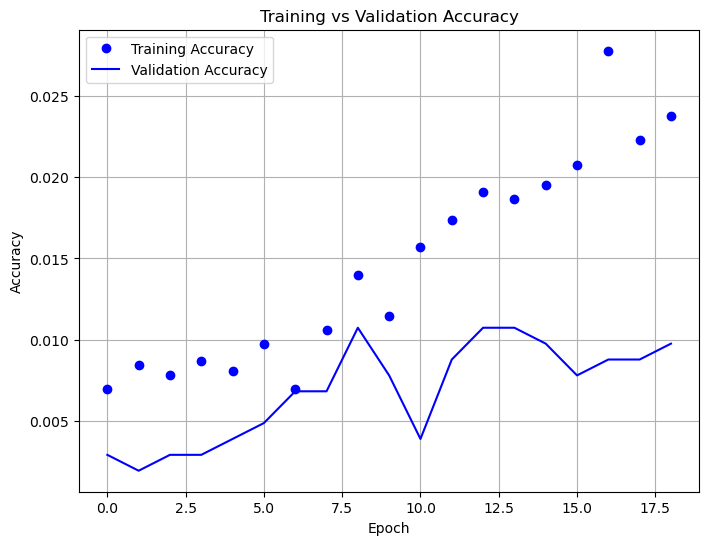

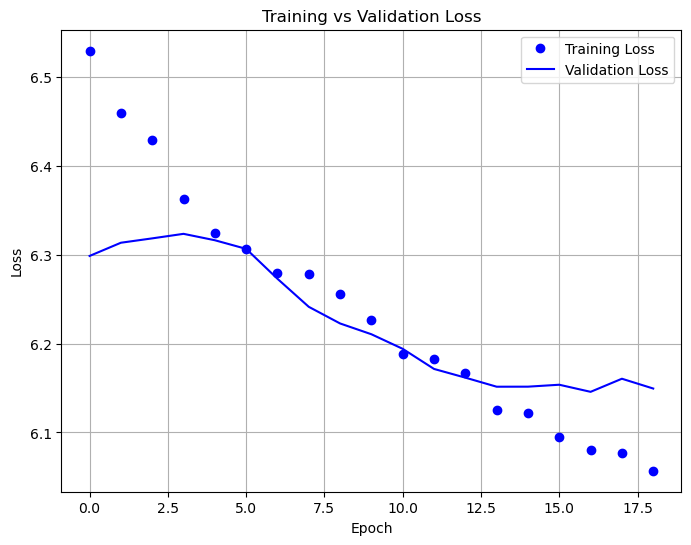

In [13]:
# Check what's available
print("Available history keys:", history.history.keys())

# Use exact metric keys
acc = history.history.get('accuracy') or history.history.get('categorical_accuracy')
val_acc = history.history.get('val_accuracy') or history.history.get('val_categorical_accuracy')
loss = history.history['loss']
val_loss = history.history['val_loss']

# Optional: If you computed macro F1 during training (custom callback), include it
macro_f1 = history.history.get('macro_f1')
val_macro_f1 = history.history.get('val_macro_f1')

# === Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(acc, 'bo', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# === Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss, 'bo', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# === (Optional) Plot Macro F1 if manually logged
if macro_f1 and val_macro_f1:
    plt.figure(figsize=(8, 6))
    plt.plot(macro_f1, 'go', label='Training Macro F1')
    plt.plot(val_macro_f1, 'g', label='Validation Macro F1')
    plt.title('Macro F1-score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score
import numpy as np

def evaluate_metrics_only(model, test_generator):
    # Predict probabilities
    y_probs = model.predict(test_generator, verbose=1)

    # Convert to predicted class indices
    y_pred = np.argmax(y_probs, axis=1)

    # Get true class indices from generator
    y_true = test_generator.classes[:len(y_pred)]

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Print results
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# Use it
evaluate_metrics_only(model, test_generator)

17/17 [==============================] - 56s 3s/step

Evaluation Metrics:
Accuracy: 0.0137
Macro F1-score: 0.0022
Weighted F1-score: 0.0022
Macro Precision: 0.0012
Macro Recall: 0.0197

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.0000    0.0000    0.0000         2
           2     0.0000    0.0000    0.0000         6
           3     0.0000    0.0000    0.0000         3
           4     0.0000    0.0000    0.0000         3
           5     0.0000    0.0000    0.0000        23
           6     0.0000    0.0000    0.0000         6
           7     0.0000    0.0000    0.0000         3
           8     0.0000    0.0000    0.0000         3
           9     0.0000    0.0000    0.0000         2
          10     0.0000    0.0000    0.0000         3
          11     0.0000    0.0000    0.0000         3
          12     0.0833    1.0000    0.1538         3
          13     0.0000    0.0000

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

In [15]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from time import time
import numpy as np
import pandas as pd

def evaluate_model(model, test_generator, batch_size=BATCH_SIZE, class_names=None):
    """
    Model evaluation that prints detailed metrics without confusion matrix plot.
    """
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    # Predict
    start_time = time()
    steps = np.ceil(test_generator.samples / batch_size)
    pred_probs = model.predict(test_generator, steps=steps, verbose=1)
    y_pred = np.argmax(pred_probs, axis=1)
    y_true = test_generator.classes[:len(y_pred)]

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n Evaluation completed in {time()-start_time:.2f} seconds\n")
    print(f"Accuracy          : {accuracy:.4f}")
    print(f"Macro F1-Score    : {macro_f1:.4f}")
    print(f"Weighted F1-Score : {weighted_f1:.4f}")
    print(f"Macro Precision   : {macro_precision:.4f}")
    print(f"Macro Recall      : {macro_recall:.4f}")

    # Classification report
    print("\n" + "-"*40)
    print("Detailed Classification Report (sample):")
    print("-"*40)
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names,
        digits=4, output_dict=True, zero_division=0
    )
    
    # Show as matrix (DataFrame sample, head only if long)
    report_df = pd.DataFrame(report_dict).transpose()
    print(report_df.head(10))  # Show only first 10 rows to prevent overload

    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "metrics": {
            "accuracy": accuracy,
            "macro_f1": macro_f1,
            "weighted_f1": weighted_f1,
            "macro_precision": macro_precision,
            "macro_recall": macro_recall
        },
        "report_df": report_df
    }

# === Usage ===
class_names = list(test_generator.class_indices.keys())

results = evaluate_model(
    model=model,
    test_generator=test_generator,
    batch_size=BATCH_SIZE,
    class_names=class_names
)



MODEL EVALUATION
17/17 [==============================] - 45s 3s/step

 Evaluation completed in 45.85 seconds

Accuracy          : 0.0137
Macro F1-Score    : 0.0022
Weighted F1-Score : 0.0022
Macro Precision   : 0.0012
Macro Recall      : 0.0197

----------------------------------------
Detailed Classification Report (sample):
----------------------------------------
                           precision  recall  f1-score  support
arthropoda_apidae                0.0     0.0       0.0     14.0
arthropoda_attelabidae           0.0     0.0       0.0      2.0
arthropoda_carabidae             0.0     0.0       0.0      6.0
arthropoda_cerambycidae          0.0     0.0       0.0      3.0
arthropoda_coenagrionidae        0.0     0.0       0.0      3.0
arthropoda_formicidae            0.0     0.0       0.0     23.0
arthropoda_gomphidae             0.0     0.0       0.0      6.0
arthropoda_lucanidae             0.0     0.0       0.0      3.0
arthropoda_nymphalidae           0.0     0.0       0.

🔹 6. Functional API (Multi-Output Model)

- Uses a shared CNN feature extractor
- Predicts Phylum (coarse class) and Family (fine class)
- Combines phylum output back into the family prediction head
- Uses modular, named layers for clarity
- Is ready for multi-loss compilation and visualization

In [16]:
# === Load updated metadata ===
metadata_path = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\metadata.csv"
metadata = pd.read_csv(metadata_path)

# === Encode categorical labels ===
metadata['phylum_id'] = metadata['phylum'].astype('category').cat.codes
metadata['family_id'] = metadata['family'].astype('category').cat.codes

# === Split directly from 'split' column ===
train_df = metadata[metadata['split'] == 'train']
val_df = metadata[metadata['split'] == 'val']
test_df = metadata[metadata['split'] == 'test']

# === Preprocessing function ===
def process(file_path, phylum_id, family_id):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    return img, {
        'phylum_output': tf.cast(phylum_id, tf.int32),
        'family_output': tf.cast(family_id, tf.int32)
    }

def make_dataset(df, batch_size=64, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df['file_path'], df['phylum_id'], df['family_id']))
    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# === Final tf.data.Datasets ===
train_dataset = make_dataset(train_df)
val_dataset = make_dataset(val_df, shuffle=False)
test_dataset = make_dataset(test_df, shuffle=False)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, Activation, Concatenate
)
from tensorflow.keras import regularizers

def build_multitask_species_model(input_shape=(224, 224, 3), num_phyla=5, num_families=202):
    l2 = regularizers.l2(0.0005)
    inputs = Input(shape=input_shape, name="image_input")

    # === Block 1 ===
    x = Conv2D(64, (3, 3), strides=1, padding='same', kernel_regularizer=l2, name="conv1")(inputs)
    x = BatchNormalization(name="bn1")(x)
    x = Activation('relu', name="act1")(x)
    x = MaxPooling2D((2, 2), name="pool1")(x)
    x = Dropout(0.1, name="drop1")(x)

    # === Block 2 ===
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2, name="conv2a")(x)
    x = BatchNormalization(name="bn2a")(x)
    x = Activation('relu', name="act2a")(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2, name="conv2b")(x)
    x = BatchNormalization(name="bn2b")(x)
    x = Activation('relu', name="act2b")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)
    x = Dropout(0.2, name="drop2")(x)

    # === Block 3 ===
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2, name="conv3")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Activation('relu', name="act3")(x)
    x = MaxPooling2D((2, 2), name="pool3")(x)
    x = Dropout(0.3, name="drop3")(x)

    # === Block 4 ===
    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2, name="conv4")(x)
    x = BatchNormalization(name="bn4")(x)
    x = Activation('relu', name="act4")(x)
    x = MaxPooling2D((2, 2), name="pool4")(x)
    x = Dropout(0.4, name="drop4")(x)

    # === Block 5 ===
    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2, name="conv5")(x)
    x = BatchNormalization(name="bn5")(x)
    x = Activation('relu', name="act5")(x)
    x = GlobalAveragePooling2D(name="gap")(x)
    x = Dropout(0.4, name="drop5")(x)

    # === Shared Dense Base ===
    base_features = Dense(512, kernel_regularizer=l2, name="dense_shared_1")(x)
    base_features = BatchNormalization(name="bn_fc_1")(base_features)
    base_features = Activation('relu', name="act_fc_1")(base_features)
    base_features = Dropout(0.5, name="drop_fc_1")(base_features)

    base_features = Dense(128, kernel_regularizer=l2, name="dense_shared_2")(base_features)
    base_features = BatchNormalization(name="bn_fc_2")(base_features)
    base_features = Activation('relu', name="act_fc_2")(base_features)
    base_features = Dropout(0.3, name="drop_fc_2")(base_features)

    # === Phylum Output ===
    phylum_branch = Dense(64, activation='relu', name="phylum_fc")(base_features)
    phylum_output = Dense(num_phyla, activation='softmax', name="phylum_output")(phylum_branch)

    # === Family Output (Conditioned on Phylum) ===
    concat = Concatenate(name="concat_family_phylum")([base_features, phylum_output])
    family_branch = Dense(256, activation='relu', name="family_fc")(concat)
    family_output = Dense(num_families, activation='softmax', name="family_output")(family_branch)

    return Model(inputs=inputs, outputs=[phylum_output, family_output], name="Multitask_Species_Model")

In [18]:
num_phyla = metadata['phylum'].nunique()
num_families = metadata['family'].nunique()

model = build_multitask_species_model(
    input_shape=(224, 224, 3),
    num_phyla=num_phyla,
    num_families=num_families
)

In [19]:
# === Compile Functional Multitask Model ===
model.compile(
    optimizer='adam',
    loss={
        'phylum_output': 'sparse_categorical_crossentropy',
        'family_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'phylum_output': 0.5,
        'family_output': 1.0
    },
    metrics={
        'phylum_output': ['accuracy'],
        'family_output': ['accuracy']
    }
)

model.summary()


Model: "Multitask_Species_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 224, 224, 64  1792        ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 224, 224, 64  256         ['conv1[0][0]']                  
                                )                                           

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# === Training Callbacks ===
callbacks = [
    EarlyStopping(
        monitor='val_family_output_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        "best_multitask_model.h5",
        monitor='val_family_output_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_family_output_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [21]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 6.5057 - phylum_output_loss: 0.8299 - family_output_loss: 5.1251 - phylum_output_accuracy: 0.7672 - family_output_accuracy: 0.0328
Epoch 1: val_family_output_accuracy improved from -inf to 0.03711, saving model to best_multitask_model.h5
75/75 [==============================] - 729s 9s/step - loss: 6.5057 - phylum_output_loss: 0.8299 - family_output_loss: 5.1251 - phylum_output_accuracy: 0.7672 - family_output_accuracy: 0.0328 - val_loss: 6.2721 - val_phylum_output_loss: 0.6941 - val_family_output_loss: 5.0492 - val_phylum_output_accuracy: 0.8311 - val_family_output_accuracy: 0.0371 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 6.0135 - phylum_output_loss: 0.6448 - family_output_loss: 4.9199 - phylum_output_accuracy: 0.8272 - family_output_accuracy: 0.0538
Epoch 2: val_family_output_accuracy did not improve from 0.03711
75/75 [==============================] - 712s 9s/step - loss: 6.0

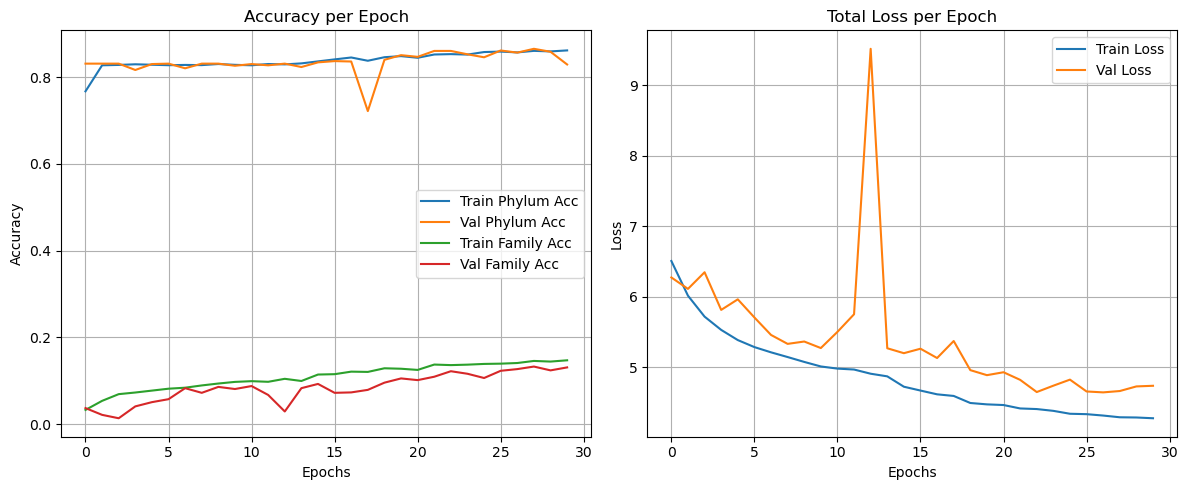

In [22]:
def plot_training(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['phylum_output_accuracy'], label='Train Phylum Acc')
    plt.plot(history.history['val_phylum_output_accuracy'], label='Val Phylum Acc')
    plt.plot(history.history['family_output_accuracy'], label='Train Family Acc')
    plt.plot(history.history['val_family_output_accuracy'], label='Val Family Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Total Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training(history)

In [23]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# === Run Predictions ===
predictions = model.predict(test_dataset)

# Unpack predictions
y_pred_phylum = np.argmax(predictions[0], axis=1)
y_pred_family = np.argmax(predictions[1], axis=1)

# Extract true labels (already integer-encoded, not one-hot)
y_true_phylum = np.concatenate([y["phylum_output"] for _, y in test_dataset], axis=0)
y_true_family = np.concatenate([y["family_output"] for _, y in test_dataset], axis=0)

# === Evaluation ===
print(" Phylum Classification Report:")
print(classification_report(y_true_phylum, y_pred_phylum))

print("\n Family Classification Report:")
print(classification_report(y_true_family, y_pred_family))

17/17 [==============================] - 38s 2s/step
 Phylum Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.31      0.43        84
           1       0.91      0.91      0.91       845
           2       0.42      0.81      0.56        72
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        19

    accuracy                           0.83      1025
   macro avg       0.40      0.41      0.38      1025
weighted avg       0.83      0.83      0.82      1025


 Family Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.27      0.23        11
           1       0.00      0.00      0.00         8
           2       0.06      0.42      0.11        19
           3       0.00      0.00      0.00         6
           4       0.05      0.18      0.08        11
           5       0.00      0.00      0.00         2
           6    

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

In [24]:
print("📊 Classification Report — Phylum (Coarse Level):\n")
print(classification_report(y_true_phylum, y_pred_phylum, digits=4))
print("🎯 Macro F1-score (Phylum):", f1_score(y_true_phylum, y_pred_phylum, average='macro'))

📊 Classification Report — Phylum (Coarse Level):

              precision    recall  f1-score   support

           0     0.6842    0.3095    0.4262        84
           1     0.9059    0.9112    0.9086       845
           2     0.4234    0.8056    0.5550        72
           3     0.0000    0.0000    0.0000         5
           4     0.0000    0.0000    0.0000        19

    accuracy                         0.8332      1025
   macro avg     0.4027    0.4053    0.3780      1025
weighted avg     0.8326    0.8332    0.8229      1025

🎯 Macro F1-score (Phylum): 0.37796160078261676


c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
print("📊 Classification Report — Family (Fine Level):\n")
print(classification_report(y_true_family, y_pred_family, digits=4))
print("🎯 Macro F1-score (Family):", f1_score(y_true_family, y_pred_family, average='macro'))

📊 Classification Report — Family (Fine Level):

              precision    recall  f1-score   support

           0     0.2000    0.2727    0.2308        11
           1     0.0000    0.0000    0.0000         8
           2     0.0611    0.4211    0.1067        19
           3     0.0000    0.0000    0.0000         6
           4     0.0526    0.1818    0.0816        11
           5     0.0000    0.0000    0.0000         2
           6     0.0000    0.0000    0.0000         2
           7     0.0000    0.0000    0.0000         3
           8     0.0000    0.0000    0.0000         5
           9     0.0000    0.0000    0.0000         5
          10     0.0000    0.0000    0.0000        15
          11     0.0000    0.0000    0.0000         6
          12     0.1538    0.6667    0.2500         3
          13     0.4074    0.7857    0.5366        14
          14     0.5000    0.1667    0.2500         6
          15     0.0000    0.0000    0.0000         2
          16     0.0000    0.0000

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
